# Libraries

In [ ]:
pip install tensorflow==2.9.1

Python interpreter will be restarted.
  Using cached tensorflow-2.9.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Not uninstalling tensorboard-data-server at /local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-801fd181-ebd2-40fc-9008-afdcd8f260a0
    Can't uninst

In [ ]:
from functions import *

  Using cached numba-0.53.0-cp39-cp39-manylinux2014_x86_64.whl (3.4 MB)
  Using cached llvmlite-0.36.0-cp39-cp39-manylinux2010_x86_64.whl (25.3 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Not uninstalling llvmlite at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-52f2f15b-b5a1-40e3-9670-e77778762e9a
    Can't uninstall 'llvmlite'. No files were found to uninstall.
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Not uninstalling numba at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-52f2f15b-b5a1-40e3-9670-e77778762e9a
    Can't uninstall 'numba'. No files were found to uninstall.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-52f2f15b-b5a1-40e3-9670-e77778762e9a/bin/python -m pip install --upgrade pip' command.


In [ ]:
np.random.seed(7) 
seed=7

In [ ]:
dataDir='/' #Give the path for your data directory

In [ ]:
!pip install mlflow kmodes kshape shap tslearn scikeras

  Using cached scikeras-0.10.0-py3-none-any.whl (27 kB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-801fd181-ebd2-40fc-9008-afdcd8f260a0/bin/python -m pip install --upgrade pip' command.


In [ ]:
#### IMPORT Leonardo

from scikeras.wrappers import KerasClassifier, KerasRegressor
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import itertools
from sklearn.model_selection import StratifiedShuffleSplit

# Functions

In [ ]:
"""#==================================================================================================="""
"""#============================================== Functions =========================================="""
"""#==================================================================================================="""
def import_json(json_path):
    df = pd.read_json(json_path)
    normalized_data = pd.json_normalize(df.iloc[0,0])
    normalized_data['time'] = pd.to_datetime(normalized_data['time'], utc=True)
    normalized_data = normalized_data.set_index('time')
    return normalized_data

#================== Evaluating the model ================
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    #mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    #return map
    sum_ae = 0.0
    mean_Yactual = np.mean(Y_actual)
    for jj in range(len(Y_actual)):
        if Y_actual[jj]==0:
            sum_ae = sum_ae + np.abs((Y_actual[jj] - Y_Predicted[jj])/mean_Yactual)
        else:
            sum_ae = sum_ae + np.abs((Y_actual[jj] - Y_Predicted[jj])/Y_actual[jj])
        mape = (sum_ae/len(Y_actual))*100
    return mape

def add_calendar_components(data, calendar_components=None, drop_constant_columns=False):
    """
    Add calendar components year, quarter, month, weekday, dayofyear, hour
    to the input DataFrame.

    :param data: input DataFrame with a DateTimeIndex and at least one column.
    :param calendar_components: List of strings, specifying the calendar components you want to add in
        ["year", "quarter", "month", "week", "day", "hour"].
    :param drop_constant_columns: If True, drops constant calendar components.
    :return: new DataFrame with the added calendar components.
    """

    if data.empty or not isinstance(data, pd.DataFrame) or not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("Input must be a non-empty pandas DataFrame with a DateTimeIndex.")

    default_components = ["year", "quarter", "month", "weekday", "dayofyear", "hour"]

    if calendar_components is not None:
        if not set(calendar_components).issubset(default_components):
            raise ValueError("Argument 'calendar_components' must be a subset of "
                             "['year', 'quarter', 'month', 'weekday', 'dayofyear', 'hour'].")
    else:
        calendar_components = default_components

    df_new = data.assign(**{
        '{}'.format(component): getattr(data.index, component)
        for component in calendar_components
    })

    if drop_constant_columns:
        df_new = df_new.loc[:, (df_new[calendar_components] != df_new.iloc[0]).any()]

    return df_new

# Data Loading & Preprocessing

In [ ]:
def data_loading_preprocessing(path, plot_consumption_per_house = False, to_csv_name = None):
    """
    It reads the data from the path, converts the time column to datetime, sets the time column as the
    index, creates a dictionary of dataframes for each house, and plots the consumption per house if the
    user wants to

    :param path: the path to the folder containing the data
    :param plot_consumption_per_house: If True, it will plot the consumption per house, defaults to
    False (optional)
    :param to_csv_name: if you want to save the dataframe to a csv file, you can specify the name of the
    file here
    :return: A tuple of two dataframes. The first one is the original dataframe, the second one is a
    dictionary of dataframes, each one corresponding to a house.
    """
    assert isinstance(to_csv_name, str) or to_csv_name is None, ("Please indicate a str path")

    df_data = pd.read_csv(path, index_col = 0)

    df_data.rename(columns={"time": "unix_time"}, inplace=True)
    df_data['time']= pd.to_datetime(df_data['unix_time'], utc=True) #use time column to then change it to datetime format
    df_data = df_data.set_index('time')
    df_data = add_calendar_components(df_data)

    # Creation of a unique dataframe for each dataid (house)
    df_unique_houses = dict()
    for houseID, data in df_data.groupby('dataid'):
        df_unique_houses[houseID] = data
  
    #if user wants to show graph
    if plot_consumption_per_house:
        plt.rcParams["figure.figsize"] = [12,4]
        plt.rcParams["font.family"] = "DejaVu Sans"

    for houseID, data in df_unique_houses.items():
        plt.plot(data["value"], label = str(houseID))
      
    plt.xlabel('Date')
    plt.ylabel('Power (W)')
    plt.title("Visualization : data for {} households".format(len(df_unique_houses.keys())))
    plt.legend()
    plt.show()

    if to_csv_name is not None and isinstance(to_csv_name, str):
        df_data.to_csv(os.path.join(os.getcwd(),to_csv_name))

    return df_data, df_unique_houses

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


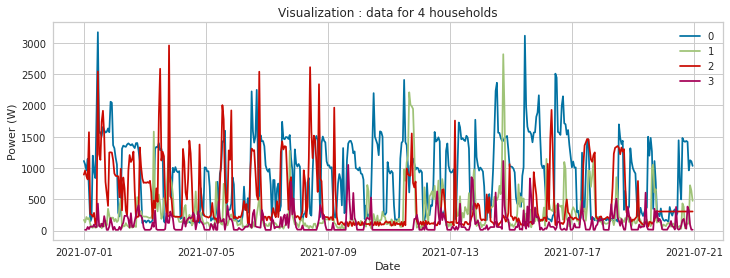

In [ ]:
dataset_with_metadata, df_unique_houses = data_loading_preprocessing(
    "bigg_data.csv", plot_consumption_per_house = True, to_csv_name = dataDir+"dataset_with_metadata.csv")

In [ ]:
dataset_with_metadata = dataset_with_metadata[:]

In [ ]:
dataset_with_metadata

,unix_time,dataid,value,equipmentId,homeID,date,year,quarter,month,weekday,dayofyear,hour
time,,,,,,,,,,,,
2021-07-01 00:00:00+00:00,1625097600000000000,0,1112.439992,0,0,01/07/2021 12:00 AM,2021,3,7,3,182,0
2021-07-01 01:00:00+00:00,1625101200000000000,0,1054.166761,0,0,01/07/2021 01:00 AM,2021,3,7,3,182,1
2021-07-01 02:00:00+00:00,1625104800000000000,0,960.882481,0,0,01/07/2021 02:00 AM,2021,3,7,3,182,2
2021-07-01 03:00:00+00:00,1625108400000000000,0,1146.482836,0,0,01/07/2021 03:00 AM,2021,3,7,3,182,3
2021-07-01 04:00:00+00:00,1625112000000000000,0,655.548819,0,0,01/07/2021 04:00 AM,2021,3,7,3,182,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20 19:00:00+00:00,1626807600000000000,3,383.572922,3,3,20/07/2021 07:00 PM,2021,3,7,1,201,19
2021-07-20 20:00:00+00:00,1626811200000000000,3,326.438875,3,3,20/07/2021 08:00 PM,2021,3,7,1,201,20
2021-07-20 21:00:00+00:00,1626814800000000000,3,93.285707,3,3,20/07/2021 09:00 PM,2021,3,7,1,201,21


# Consumer profile features

In [ ]:
def normalize_row_avg(row,df):
    """
    For each row in the dataframe, divide the value by the mean of the values for that dataid

    :param row: a row of the dataframe
    :param df: the dataframe
    :return: A dataframe with the normalized values.
    """
    dataid = row['dataid']
    return row['value']/df.loc[dataid]['mean']

def consumer_profile_features(dataset_with_metadata, to_csv_name = None):
    """
    It takes a dataframe with the following columns:
    
    - dataid
    - value
    - hour
    - weekday
    - month
    - dayofyear
    - year
    
    and returns a dataframe with the following columns:
    
    - mean_over_max
    - min_over_mean
    - var
    - mean
    - max
    - min
    - Relative average consumption 1
    - Relative average consumption 2
    - Relative average consumption 3
    - Relative average consumption 4
    - Mean relative standard deviation
    - Weekend vs weekday difference score
    
    The function also returns two other dataframes:
    
    - load_profiles: a dataframe with the normalized load profiles for each house
    - clustering_profiles_weekend_weekday_difference_score: a dataframe with the same columns as the one
    returned by
    
    :param dataset_with_metadata: the dataset with the metadata
    :param to_csv_name: the name of the file you want to save the output to. If you don't want to save
    it, leave it as None
    :return: a tuple of 3 dataframes (clustering_profiles, load_profiles, clustering_profiles_weekend_weekday_difference_score)
    """

    assert isinstance(to_csv_name, str) or to_csv_name is None, ("Please indicate a str path")

    use_per_house = dataset_with_metadata.groupby(['dataid'], axis=0)['value'].agg(['min', 'max', 'mean', 'var', 'std'])

    use_per_house_weekdays = dataset_with_metadata.loc[
        dataset_with_metadata['weekday'].isin([0,1,2,3,4])].groupby(['dataid'], axis=0)['value'].agg(['min', 'max', 'mean'])

    use_per_house_weekends = dataset_with_metadata.loc[
        dataset_with_metadata['weekday'].isin([5,6])].groupby(['dataid'], axis=0)['value'].agg(['min', 'max', 'mean'])

    use_per_house_per_hour = dataset_with_metadata.groupby(['dataid','hour'], axis=0)['value'].mean()
    use_per_house_per_hour = pd.DataFrame(use_per_house_per_hour).reset_index()

    use_per_house_per_hour['normalized_use_mean'] = use_per_house_per_hour.apply(lambda row: normalize_row_avg(row, use_per_house), axis=1)

    load_profiles = pd.DataFrame(use_per_house_per_hour).reset_index().pivot(
        index='dataid',columns='hour',values='normalized_use_mean').dropna()

    daily_consumption = dataset_with_metadata.groupby(
        ['dataid', 'weekday', 'month', 'dayofyear', 'year'], axis=0)['value'].sum().reset_index()

    daily_consumption_avg = daily_consumption.groupby(['dataid'], axis=0)['value'].mean().reset_index()
    daily_consumption_avg.rename(columns={'value': 'TotalDailyEnergyMean(Wh)'}, inplace=True)

    daily_consumption_avg_weekday = daily_consumption.loc[
        daily_consumption['weekday'].isin([0,1,2,3,4])].groupby(['dataid'], axis=0)['value'].mean().reset_index()

    daily_consumption_avg_weekend = daily_consumption.loc[
        daily_consumption['weekday'].isin([5,6])].groupby(['dataid'], axis=0)['value'].mean().reset_index()
    
    daily_consumption_max = dataset_with_metadata.groupby(
        ['dataid', 'month', 'dayofyear', 'year'], axis=0)['value'].max().reset_index()

    daily_consumption_min = dataset_with_metadata.groupby(
        ['dataid', 'month', 'dayofyear', 'year'], axis=0)['value'].min().reset_index()

    daily_consumption_mean = dataset_with_metadata.groupby(
        ['dataid', 'month', 'dayofyear', 'year'], axis=0)['value'].mean().reset_index()

    use_per_house['mean_over_max'] = use_per_house['mean'] / use_per_house['max'] 

    use_per_house['min_over_mean'] = use_per_house['min'] / use_per_house['mean'] 

    ## Time Period 1 - Overnight - 22:00-6:00 ##

    # Mean
    p_1 = dataset_with_metadata.loc[
        (dataset_with_metadata['hour'] >= 22) | (dataset_with_metadata['hour'] < 6)
    ].groupby(['dataid'], axis=0)['value'].agg(['mean', 'std'])

    # Summer mean
    ps_1 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([6,7,8])) & ((dataset_with_metadata['hour'] >= 22) | (dataset_with_metadata['hour'] < 6))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Winter mean
    pw_1 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([12,1,2])) & ((dataset_with_metadata['hour'] >= 22) | (dataset_with_metadata['hour'] < 6))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekday mean
    pwd_1 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([0,1,2,3,4])) & ((dataset_with_metadata['hour'] >= 22) | (dataset_with_metadata['hour'] < 6))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekend mean
    pwe_1 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([5,6])) & ((dataset_with_metadata['hour'] >= 22) | (dataset_with_metadata['hour'] < 6))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Relative average consumption
    pr_1 = pd.DataFrame(p_1['mean'] / use_per_house['mean'])
    pr_1.rename(columns={'mean': 'Relative average consumption 1'}, inplace=True)


    ## Time Period 2 - Breakfast - 6:00-9:00 ##

    # Mean
    p_2 = dataset_with_metadata.loc[
        (dataset_with_metadata['hour'] >= 6) & (dataset_with_metadata['hour'] < 9)
    ].groupby(['dataid'], axis=0)['value'].agg(['mean', 'std'])

    # Summer mean
    ps_2 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([6,7,8])) & ((dataset_with_metadata['hour'] >= 6) & (dataset_with_metadata['hour'] < 9))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Winter mean
    pw_2 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([12,1,2])) & ((dataset_with_metadata['hour'] >= 6) & (dataset_with_metadata['hour'] < 9))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekday mean
    pwd_2 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([0,1,2,3,4])) & ((dataset_with_metadata['hour'] >= 6) & (dataset_with_metadata['hour'] < 9))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekend mean
    pwe_2 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([5,6])) & ((dataset_with_metadata['hour'] >= 6) & (dataset_with_metadata['hour'] < 9))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Relative average consumption
    pr_2 = pd.DataFrame(p_2['mean'] / use_per_house['mean'])
    pr_2.rename(columns={'mean': 'Relative average consumption 2'}, inplace=True)

    ## Time Period 3 - Daytime - 9:00-15:00 ##

    # Mean
    p_3 = dataset_with_metadata.loc[
        (dataset_with_metadata['hour'] >= 9) & (dataset_with_metadata['hour'] < 15)
    ].groupby(['dataid'], axis=0)['value'].agg(['mean', 'std'])

    # Summer mean
    ps_3 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([6,7,8])) & ((dataset_with_metadata['hour'] >= 9) & (dataset_with_metadata['hour'] < 15))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Winter mean
    pw_3 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([12,1,2])) & ((dataset_with_metadata['hour'] >= 9) & (dataset_with_metadata['hour'] < 15))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekday mean
    pwd_3 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([0,1,2,3,4])) & ((dataset_with_metadata['hour'] >= 9) & (dataset_with_metadata['hour'] < 15))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekend mean
    pwe_3 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([5,6])) & ((dataset_with_metadata['hour'] >= 9) & (dataset_with_metadata['hour'] < 15))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Relative average consumption
    pr_3 = pd.DataFrame(p_3['mean'] / use_per_house['mean'])
    pr_3.rename(columns={'mean': 'Relative average consumption 3'}, inplace=True)

    ## Time Period 4 - Evening - 15:00-22:00 ##

    # Mean
    p_4 = dataset_with_metadata.loc[
        (dataset_with_metadata['hour'] >= 15) & (dataset_with_metadata['hour'] < 22)
    ].groupby(['dataid'], axis=0)['value'].agg(['mean', 'std'])

    # Summer mean
    ps_4 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([6,7,8])) & ((dataset_with_metadata['hour'] >= 15) & (dataset_with_metadata['hour'] < 22))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Winter mean
    pw_4 = dataset_with_metadata.loc[
        (dataset_with_metadata['month'].isin([12,1,2])) & ((dataset_with_metadata['hour'] >= 15) & (dataset_with_metadata['hour'] < 22))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekday mean
    pwd_4 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([0,1,2,3,4])) & ((dataset_with_metadata['hour'] >= 15) & (dataset_with_metadata['hour'] < 22))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Weekend mean
    pwe_4 = dataset_with_metadata.loc[
        (dataset_with_metadata['weekday'].isin([5,6])) & ((dataset_with_metadata['hour'] >= 15) & (dataset_with_metadata['hour'] < 22))
    ].groupby(['dataid'], axis=0)['value'].mean()

    # Relative average consumption
    pr_4 = pd.DataFrame(p_4['mean'] / use_per_house['mean'])
    pr_4.rename(columns={'mean': 'Relative average consumption 4'}, inplace=True)

    mean_relative_std = pd.DataFrame(pd.Series(
        (1/4) * sum([p_1['std']/p_1['mean'], p_2['std']/p_2['mean'], p_3['std']/p_3['mean'], p_4['std']/p_4['mean']]), name='mean'))
    mean_relative_std.rename(columns={'mean': 'Mean relative standard deviation'}, inplace=True)

    seasonal_score = pd.DataFrame(pd.Series(
        sum([abs(pw_1 - ps_1)/p_1['mean'],
             abs(pw_2 - ps_2)/p_2['mean'],
             abs(pw_3 - ps_3)/p_3['mean'],
             abs(pw_4 - ps_4)/p_4['mean']]), name='mean')) # Il manque la division par 4 /!\ /!\ /!\ /!\
    seasonal_score.rename(columns={'mean': 'Seasonal score'}, inplace=True)

    weekend_weekday_difference_score = pd.DataFrame(pd.Series(
        sum([abs(pwd_1 - pwe_1)/p_1['mean'],
             abs(pwd_2 - pwe_2)/p_2['mean'],
             abs(pwd_3 - pwe_3)/p_3['mean'],
             abs(pwd_4 - pwe_4)/p_4['mean']]), name='mean')) # Il manque la division par 4 /!\ /!\ /!\ /!\
    weekend_weekday_difference_score.rename(columns={'mean': 'Weekend vs weekday difference score'}, inplace=True)

    # scaler = MinMaxScaler()
    # use_per_house[use_per_house.columns] = scaler.fit_transform(use_per_house[use_per_house.columns])

    clustering_profiles = load_profiles \
    .merge(use_per_house['mean_over_max'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['min_over_mean'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['var'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['mean'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['max'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['min'], left_index=True, right_index=True, how='inner') \
    .merge(pr_1, left_index=True, right_index=True, how='inner') \
    .merge(pr_2, left_index=True, right_index=True, how='inner') \
    .merge(pr_3, left_index=True, right_index=True, how='inner') \
    .merge(pr_4, left_index=True, right_index=True, how='inner') \
    .merge(mean_relative_std, left_index=True, right_index=True, how='inner') \
    .merge(weekend_weekday_difference_score, left_index=True, right_index=True, how='inner')
    # .merge(seasonal_score, left_index=True, right_index=True, how='inner') \

    clustering_profiles_weekend_weekday_difference_score = weekend_weekday_difference_score \
    .merge(use_per_house['mean_over_max'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['min_over_mean'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['var'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['mean'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['max'], left_index=True, right_index=True, how='inner') \
    .merge(use_per_house['min'], left_index=True, right_index=True, how='inner') \
    .merge(pr_1, left_index=True, right_index=True, how='inner') \
    .merge(pr_2, left_index=True, right_index=True, how='inner') \
    .merge(pr_3, left_index=True, right_index=True, how='inner') \
    .merge(pr_4, left_index=True, right_index=True, how='inner') \
    .merge(mean_relative_std, left_index=True, right_index=True, how='inner') \
    # .merge(seasonal_score, left_index=True, right_index=True, how='inner') \

    clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]

    if to_csv_name is not None and isinstance(to_csv_name, str):
        clustering_profiles.to_csv(os.path.join(os.getcwd(),to_csv_name))

    return clustering_profiles, load_profiles, clustering_profiles_weekend_weekday_difference_score

In [ ]:
# clustering_profiles_metadata, load_profiles, clustering_profiles_weekend_weekday_difference_score = consumer_profile_features(dataset_with_metadata, to_csv_name = dataDir+"IC_clustering_profiles_metadata.csv")
clustering_profiles_metadata, load_profiles, clustering_profiles_weekend_weekday_difference_score = consumer_profile_features(dataset_with_metadata)

In [ ]:
clustering_profiles_metadata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,mean_over_max,min_over_mean,var,mean,max,min,Relative average consumption 1,Relative average consumption 2,Relative average consumption 3,Relative average consumption 4,Mean relative standard deviation,Weekend vs weekday difference score
dataid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.972626,0.949175,0.924144,0.714825,0.321005,0.308839,0.486333,0.538034,0.661215,0.770505,0.795908,1.309027,1.732782,1.549520,1.424102,1.410264,1.274202,1.137157,1.082905,1.164427,1.133305,1.118003,1.180917,1.040780,0.276307,0.130970,342526.157037,875.714187,3169.347975,114.692350,0.801539,0.561861,1.263641,1.188609,0.659908,1.410687
1,0.519650,0.483819,0.568319,0.458953,1.068011,0.764701,0.674059,1.027589,1.058414,0.727537,0.748020,0.808838,1.038637,0.928045,1.085131,1.546945,1.451414,1.500709,2.442544,1.892987,1.209162,0.826801,0.647667,0.522048,0.097967,0.097482,106694.887040,276.029719,2817.589925,26.908044,0.629146,0.920021,0.889368,1.552937,0.999076,1.699126
2,0.603909,0.598475,0.585643,0.593703,0.878255,0.969913,0.681149,0.780147,0.787052,0.822042,0.988012,1.602754,1.613136,1.494173,1.551243,1.389852,1.022382,1.053106,1.376275,1.370431,1.120518,0.787026,0.653020,0.677784,0.161710,0.134131,253148.650400,478.357386,2958.112197,64.162786,0.695088,0.749449,1.345227,1.159942,0.981387,1.133667
3,0.226551,0.121576,0.191343,0.204620,0.407934,0.511485,0.641066,0.852579,1.081249,0.655471,1.633244,1.001199,0.720430,1.210073,1.070748,1.230007,1.473206,1.672285,1.959998,2.036890,1.861490,1.745045,1.134594,0.318244,0.101477,0.093232,23273.980996,112.788661,1111.469983,10.515567,0.390569,0.858298,1.048528,1.711274,1.156729,1.873913


### Time series clustering

In [ ]:
def hopkins(X):
    """
    The function takes a dataframe as input and returns the Hopkins statistic, which is a measure of the
    clustering tendency of the data.
    
    The Hopkins statistic, in turn, ranges from 0 to 1. Its interpretation is as follows:
    
    A value of 0 means that the data is not clustered at all
    A value of 0.5 means that the structure is lost due to the lack of data
    A value of 1 means that the data is clustered perfectly
    
    :param X: the dataframe
    :return: The Hopkins statistic, which is a value between {0.01, ..., 0.3}. The lower the value, the
    more likely it is that the data is clustered.
    """
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = 1 #int(0.1 * n) # heuristic from article [1] # En attendant qu'on ait plus de données (au moins 10 foyers/devices) /!\ /!\ /!\ /!\
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = random.Random(seed).sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
    return H

def time_series_clustering(load_profiles, path_pickle_load = None,
    path_pickle= dataDir+"IC_timeseries_kmeans.pkl", visualise_KMeans_clustering = False, to_csv_name = None):
    """
    It takes a dataframe of load profiles, and returns a dataframe of load profiles with a column
    indicating the cluster to which each profile belongs
    
    :param load_profiles: the dataframe of the load profiles
    :param path_pickle: the path to the pickle file where the model will be saved, defaults to
    IC_timeseries_kmeans.pkl (optional)
    :param visualise_KMeans_clustering: if True, it will plot the elbow curve to help you choose the
    number of clusters, defaults to False (optional)
    :param to_csv_name: the name of the csv file you want to save the results to
    :return: A dataframe with the cluster number for each dataid
    """
    assert isinstance(to_csv_name, str) or to_csv_name is None, ("Please indicate a str path")

    clustering_profiles = load_profiles

    clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]

    X = np.array(clustering_profiles)

    X = X.reshape(X.shape[0],X.shape[1], 1) # Si on fait ce reshaping, la fonction de test de hopkins donne une erreur 

    # Instantiate the clustering model and visualizer
    model = TimeSeriesKMeans(random_state=123, verbose= 0, metric="softdtw")

    if visualise_KMeans_clustering:
        visualizer = KElbowVisualizer(model, k=(1,4), timings=False, size=(400, 400))
        # En attendant qu'on ait plus de données (pour un nombre de cluster entre k=(2,20)) /!\ /!\ /!\ /!\

        visualizer.fit(X.reshape(X.shape[0],X.shape[1])) # Fit the data to the visualizer
        visualizer.show() # Finalize and render the figure

    if path_pickle_load is None:
        kmeans = TimeSeriesKMeans(
            n_clusters= 2, random_state=7, verbose= 0, metric="dtw"
            # Ne pas oublier de remplacer n_clusters par visualizer.elbow_value_ /!\ /!\ /!\ /!\
        ).fit(X)

        pickle.dump(kmeans, open(os.path.join(os.getcwd(),path_pickle), 'wb'))

    else:
        # open a file, where you stored the pickled data
        file = open(path_pickle_load, 'rb')

        # dump information to that file
        kmeans = pickle.load(file)

    sqr_cluster_distance = kmeans.transform(X)**2

    sqr_cluster_distance_df = pd.DataFrame(sqr_cluster_distance).add_prefix('centroid_distance_from_')

    clustering_profiles['Cluster'] = kmeans.predict(X)

    clustering_profiles = pd.merge(clustering_profiles.reset_index(), sqr_cluster_distance_df, left_index=True, right_index=True, how='inner')

    clustering_profiles.index = clustering_profiles['dataid']

    clustering_profiles = clustering_profiles.drop('dataid', 1)

    # cluster_profile = clustering_profiles.groupby('Cluster').mean()

    if to_csv_name is not None and isinstance(to_csv_name, str):
        clustering_profiles.to_csv(os.path.join(os.getcwd(),to_csv_name))

    return clustering_profiles

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning


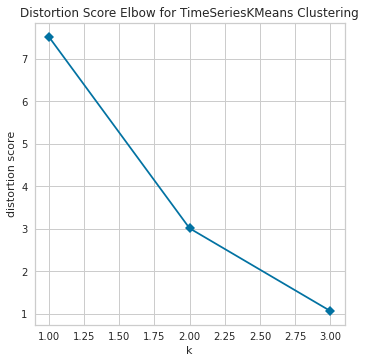

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
clustering_profiles_timeseries = time_series_clustering(load_profiles, path_pickle= dataDir+"IC_timeseries_kmeans.pkl",
    visualise_KMeans_clustering = True, to_csv_name = dataDir+"IC_clustering_profiles_timeseries.csv")

### Clustering using the non-timeseries features of the profile

In [ ]:
def non_time_series_clustering(clustering_profiles_weekend_weekday_difference_score, path_pickle_load = None,
    path_pickle= dataDir+"IC_non_timeseries_kmeans.pkl", visualise_KMeans_clustering = False, to_csv_name = None):
    """
    It takes a dataframe of profiles, and returns a dataframe of profiles with a column indicating the
    cluster to which each profile belongs
    
    :param clustering_profiles_weekend_weekday_difference_score: the dataframe that contains the data to
    be clustered
    :param path_pickle: the path to the pickle file where the KMeans model will be saved, defaults to
    IC_non_timeseries_kmeans.pkl (optional)
    :param visualise_KMeans_clustering: if True, the elbow method will be used to determine the optimal
    number of clusters, defaults to False (optional)
    :param to_csv_name: the name of the csv file to save the results to. If you don't want to save the
    results to a csv file, set this to None
    :return: A dataframe with the cluster number for each dataid
    """

    assert isinstance(to_csv_name, str) or to_csv_name is None, ("Please indicate a str path")
    
    clustering_profiles = clustering_profiles_weekend_weekday_difference_score[
        ~clustering_profiles_weekend_weekday_difference_score.isin([np.nan, np.inf, -np.inf]).any(1)]

    X = np.array(clustering_profiles)
    print(X)
    print(X.shape)

    # Instantiate the clustering model and visualizer
    model = KMeans()

    if visualise_KMeans_clustering:
        visualizer = KElbowVisualizer(model, k=(1,4), timings=False, size=(400, 400))
        # En attendant qu'on ait plus de données (pour un nombre de cluster entre k=(2,11)) /!\ /!\ /!\ /!\

        visualizer.fit(X)                # Fit the data to the visualizer
        visualizer.show()                # Finalize and render the figure

    if path_pickle_load is None:
        kmeans = KMeans(n_clusters=2, random_state=7).fit(X)
        # Ne pas oublier de remplacer n_clusters par visualizer.elbow_value_ /!\ /!\ /!\ /!\
        
        pickle.dump(kmeans, open(os.path.join(os.getcwd(),path_pickle), 'wb'))
    
    else:
        # open a file, where you stored the pickled data
        file = open(path_pickle_load, 'rb')

        # dump information to that file
        kmeans = pickle.load(file)

    clustering_profiles['Cluster'] = kmeans.predict(X)

    # cluster_profile = clustering_profiles.groupby('Cluster').mean()

    sqr_cluster_distance = kmeans.transform(X)**2

    sqr_cluster_distance_df = pd.DataFrame(sqr_cluster_distance).add_prefix('centroid_distance_from_')

    clustering_profiles['Cluster'] = kmeans.predict(X)

    clustering_profiles = pd.merge(clustering_profiles.reset_index(), sqr_cluster_distance_df, left_index=True, right_index=True, how='inner')

    clustering_profiles.index = clustering_profiles['dataid']

    clustering_profiles = clustering_profiles.drop('dataid', 1)

    # cluster_profile = clustering_profiles.groupby('Cluster').mean()

    if to_csv_name is not None and isinstance(to_csv_name, str):
        clustering_profiles.to_csv(os.path.join(os.getcwd(),to_csv_name))

    return clustering_profiles

[[1.41068702e+00 2.76307365e-01 1.30970072e-01 3.42526157e+05
  8.75714187e+02 3.16934798e+03 1.14692350e+02 8.01538813e-01
  5.61860701e-01 1.26364084e+00 1.18860891e+00 6.59908484e-01]
 [1.69912599e+00 9.79666049e-02 9.74824180e-02 1.06694887e+05
  2.76029719e+02 2.81758993e+03 2.69080444e+01 6.29146116e-01
  9.20020598e-01 8.89367977e-01 1.55293734e+00 9.99075883e-01]
 [1.13366659e+00 1.61710359e-01 1.34131484e-01 2.53148650e+05
  4.78357386e+02 2.95811220e+03 6.41627861e+01 6.95087625e-01
  7.49449396e-01 1.34522664e+00 1.15994156e+00 9.81387198e-01]
 [1.87391316e+00 1.01477019e-01 9.32324808e-02 2.32739810e+04
  1.12788661e+02 1.11146998e+03 1.05155667e+01 3.90568584e-01
  8.58298038e-01 1.04852763e+00 1.71127426e+00 1.15672865e+00]]
(4, 12)
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

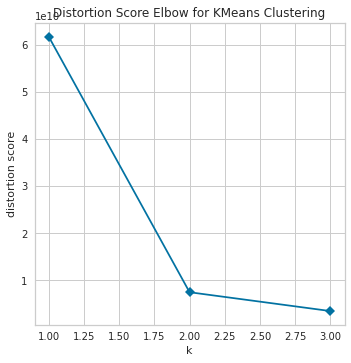

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
clustering_profiles_non_timeseries = non_time_series_clustering(
    clustering_profiles_weekend_weekday_difference_score, path_pickle=dataDir+"IC_non_timeseries_kmeans.pkl",
    visualise_KMeans_clustering = True, to_csv_name = dataDir+"IC_clustering_profiles_non-timeseries.csv")

## Consumption prediction

In [ ]:
def clustering_profiles_and_metadata(dataset_with_metadata, clustering_profiles_metadata,
    clustering_profiles_timeseries = None, clustering_profiles_non_timeseries = None,
    calculate_centroids = True, to_csv_name = None):
    """
    It takes in the dataset with metadata, the clustering profiles for the timeseries and
    non-timeseries, and returns a dataset with the clustering profiles and metadata
    
    :param dataset_with_metadata: the dataset with the metadata (e.g. month, hour, dayofyear, weekday)
    :param clustering_profiles_metadata: a dataframe with the cluster assignments for each dataid
    :param clustering_profiles_timeseries: the clustering profiles for the timeseries data
    :param clustering_profiles_non_timeseries: the non-timeseries clustering profiles
    :param to_csv_name: the name of the csv file to save the dataframe to. If None, then the dataframe
    is not saved to a csv file
    :return: A dataframe with the clustering profiles and metadata
    """

    assert isinstance(to_csv_name, str) or to_csv_name is None, ("Please indicate a str path")

    if clustering_profiles_timeseries is not None and clustering_profiles_non_timeseries is not None:
        dataset_with_metadata, clustering_profiles_timeseries, clustering_profiles_non_timeseries = dataset_with_metadata.reset_index(), clustering_profiles_timeseries.reset_index(), clustering_profiles_non_timeseries.reset_index()
    else:
        dataset_with_metadata = dataset_with_metadata.reset_index()

    if calculate_centroids:
        clustering_profiles_timeseries = clustering_profiles_timeseries.rename(
            columns={'centroid_distance_from_0': 'ts_centroid_distance_from_0', 'centroid_distance_from_1': 'ts_centroid_distance_from_1',})
        # 'centroid_distance_from_2': 'ts_centroid_distance_from_2', 'centroid_distance_from_3': 'ts_centroid_distance_from_3', 
        # 'centroid_distance_from_4': 'ts_centroid_distance_from_4', 'centroid_distance_from_5': 'ts_centroid_distance_from_5', })
        
        clustering_profiles_non_timeseries = clustering_profiles_non_timeseries.rename(
            columns={'centroid_distance_from_0': 'non_ts_centroid_distance_from_0', 'centroid_distance_from_1': 'non_ts_centroid_distance_from_1',})
        #'centroid_distance_from_2': 'non_ts_centroid_distance_from_2', 'centroid_distance_from_3': 'non_ts_centroid_distance_from_3', 
        # 'centroid_distance_from_4': 'non_ts_centroid_distance_from_4', 'centroid_distance_from_5': 'non_ts_centroid_distance_from_5', })
        
        dataset_with_clustering_profiles_and_metadata = dataset_with_metadata[
            ['dataid', 'value', 'month', 'hour', 'dayofyear', 'weekday']
            ].merge(clustering_profiles_metadata, on='dataid', how='inner')

        dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.merge(
            clustering_profiles_timeseries[['dataid', 'ts_centroid_distance_from_0', 'ts_centroid_distance_from_1']],
            on='dataid', how='inner')
        # 'ts_centroid_distance_from_2', 'ts_centroid_distance_from_3', 'ts_centroid_distance_from_4', 'ts_centroid_distance_from_5'

        dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.merge(
            clustering_profiles_non_timeseries[['dataid', 'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1']],
            on='dataid', how='inner')
        # 'non_ts_centroid_distance_from_2', 'non_ts_centroid_distance_from_3', 'non_ts_centroid_distance_from_4'

    else:
        dataset_with_clustering_profiles_and_metadata = dataset_with_metadata[
            ['dataid', 'value', 'month', 'hour', 'dayofyear', 'weekday']
            ].merge(clustering_profiles_metadata, on='dataid', how='inner')

    dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.set_index('dataid')

    # dataset_with_clustering_profiles_and_metadata = pd.read_csv(dataDir+'IC_dataset_with_clustering_profiles_and_metadata.csv')

    if to_csv_name is not None and isinstance(to_csv_name, str):
        dataset_with_clustering_profiles_and_metadata.to_csv(os.path.join(os.getcwd(),to_csv_name))
    
    return dataset_with_clustering_profiles_and_metadata

In [ ]:
dataset_with_clustering_profiles_and_metadata = clustering_profiles_and_metadata(
    dataset_with_metadata,
    clustering_profiles_metadata,
    clustering_profiles_timeseries,
    clustering_profiles_non_timeseries,
    to_csv_name = dataDir+'IC_dataset_with_clustering_profiles_and_metadata.csv')

### Skewness & Box Cox

In [ ]:
# Pickle utilities:

def pickle_save(data, filename):
    filename = dataDir+filename
    pickle.dump(data, open(os.path.join(os.getcwd(), filename), 'wb'))
    print("Saved file: %s" % filename)

def pickle_load(filename):
    filename = dataDir+filename
    assert os.path.isfile(filename), "File '%s' not found" % filename
    file = open(filename, 'rb')
    print("Loaded file: %s" % filename)
    return pickle.load(file)

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

def full_model_evaluation(y_true, y_pred, verbose = False):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nrmse = sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)
    nd = np.sum(np.abs(y_true-y_pred)) / np.sum(np.abs(y_true))
    rss = np.sum(np.square(y_true-y_pred))
    abs_diff_sum = np.sum(np.abs(y_true-y_pred))
    diff_from_mean_sum = np.sum(np.square(y_true - np.mean(y_true)))

    if verbose:
        print("Mean Absolute Percentage Error (MAPE) = "+str(mape)+ " %")
        print("R-squared = "+str(r2))
        print("Mean Squared Error (MSE) = "+str(mse))
        print("Root Mean Squared Error (RMSE) = "+str(rmse))
        print("Mean Absolute Error (MAE) = "+str(mae))
        print("Normalized Root Mean Squared Error (NRMSE) = "+str(nrmse))
        print("Normalized deviation (ND) = "+str(nd))
        print("Residual Sum of the Squares (RSS) = "+str(rss))
        print("Sum of absolute differences = "+str(abs_diff_sum))
        print("Difference from mean sum = "+str(diff_from_mean_sum))

    return mape, r2, mse, rmse, mae, nrmse, nd, rss, abs_diff_sum, diff_from_mean_sum

In [ ]:
def skewness_and_box_cox(dataset_with_clustering_profiles_and_metadata, maxlog=None):
    """
    It takes a dataframe as input, and returns a dataframe and a list of indexes

    :param dataset_with_clustering_profiles_and_metadata: the dataset with the clustering profiles and
    the metadata
    :return: The dataset with the boxcox transformation applied to the value column, and the indexes of
    the rows where the houseID changes.
    """
    dataset_with_clustering_profiles_and_metadata['value'] = dataset_with_clustering_profiles_and_metadata['value'].replace(to_replace=0, value=0.0001)

    result = tuple(stats.boxcox(dataset_with_clustering_profiles_and_metadata['value'], lmbda=maxlog))
    maxlog = result[1] if not maxlog else maxlog
    # print("maxlog:", maxlog)

    dataset_with_clustering_profiles_and_metadata['value'] = result[0]
    dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.sort_values(['dataid', 'dayofyear', 'month', 'weekday', 'hour'], ascending=[True, True, True, True, True])
    dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.reset_index()

    houseID_change_indexes = pd.DataFrame(dataset_with_clustering_profiles_and_metadata['dataid']).ne(
        pd.DataFrame(dataset_with_clustering_profiles_and_metadata['dataid']).shift()).apply(lambda x: x.index[x].tolist())#[0]
    # Attention : le [0] est présent à la fin dans la vraie version /!\ /!\ /!\ /!\

    return dataset_with_clustering_profiles_and_metadata, houseID_change_indexes, maxlog # Create new function to separate skewness_and_box_cox and houseID_change_indexes

In [ ]:
# dataset_with_clustering_profiles_and_metadata, houseID_change_indexes, box_cox, maxlog = skewness_and_box_cox(dataset_with_clustering_profiles_and_metadata)

### RNN as encoder for consumption timeseries and MLP for prediction

In [ ]:
# Choosing a number of time steps:
n_steps = 24*1

def split_sequences(sequences, n_steps, houseID_change_indexes):
    """
    It takes a 2D array of sequences and a number of time steps, and returns a 3D array of sequences and
    a 1D array of targets
    
    :param sequences: the dataset we want to split into samples
    :param n_steps: The number of time steps to include in each sample
    :return: X is a list of arrays of shape (24, 1) (24 hours of data for each house)
    y is a list of arrays of shape (1,) (the 24th hour of data for each house)
    """
    X, y = list(), list()
    # for i in range(len(sequences)):
    i = 0
    while i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # check if we are beyond of this house's time-series 
        if (end_ix in houseID_change_indexes): # A noter que les valeurs dans houseID_change_indexes sont toutes multiples de n_steps=24
            # jump n_steps ahead
            i = i + n_steps # Si jamais end_ix (qui est à chaque fois augmenté de 24, partant de 0) devient à un moment égal à une valeur dans houseID_change_indexes (toutes multiples de n_steps=24), cela veut dire qu'on à atteint/dépassé la dernière valeur d'une maison donnée. On incrémente donc i de n_steps = 24 (qui nous amène sur la maison suivante !?)
            # delete the respective row from the MLP input and output vectors
            normalizedX.drop(list(range(end_ix, end_ix + n_steps)), inplace=True) # Etant donné qu'on a incrémenté i de n_steps = 24 et qu'à chaque fois les données traitées vont de i à end_ix = i+n_steps, cela veut dire que les données entre la fin end_ix (du i avant incrémentation) et cette fin end_ix + n_steps doivent aussi être enlevées dans les données MLP correspondantes (normalizedX)
            # normalizedY.drop(list(range(end_ix, end_ix + n_steps))) # Pourquoi on ne fait plus la suppression dans normalizedY ? Dans la suite, il n'est pas vraiment utilisé !? On sera plus focalisé sur y_lstm pour les output !?
            
            continue
        else:
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1] 
            X.append(seq_x) # seq_x: on prend les lignes de i à end_ix-1 (24 heures de données) de toutes les colonnes sauf la dernière colonne (correspondant à y_lstm), donc on ne prend que la première colonne (X_lstm) [qui a été initialement shiftée d'un pas de 1 pour la prédiction de l'heure suivante] étant donné qu'on a en tout 2 colonnes
            y.append(seq_y) # seq_y: on prend la ligne  end_ix-1 (la 24ème valeur) de la dernière colonne (correspondant à y_lstm). Donc, on s'entraine à prédire la 24ème valeur à partir des données des 24 heures précédentes (incluant celle qu'on veut prédire ?)
        i = i + 1
    return array(X), array(y)

In [ ]:
def crop(dimension, start, end):
    """
    It takes a tensor and crops it along a given dimension from start to end
    
    :param dimension: the dimension to crop on
    :param start: the starting index of the slice
    :param end: the end of the slice. If you don't specify an end index, the range will extend to the
    end of the input tensor
    :return: A function that takes in a tensor and returns a tensor.
    """
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension 
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            if end == -1:
                return x[:, start:]
            else:
                return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func) # https://keras.io/api/layers/core_layers/lambda/

In [ ]:
# MinMaxScaler utilities:

def scaler_print(scaler):
    print(scaler.__dict__)

def scaler_normalize(data, columns, filename, inference, verbose=False):
    if inference:
        scaler = pickle_load(filename)
    else:
        assert len(data) > 0, "Not enough data"
        scaler = MinMaxScaler()
        scaler.fit(data) # modifies the scaler
        pickle_save(scaler, filename)
    if verbose:
        scaler_print(scaler)
    np_scaled = scaler.transform(data) # does not modify the scaler
    normalized = pd.DataFrame(data=np_scaled, columns=columns)
    return scaler, normalized

In [ ]:
def process_data(dataset_with_clustering_profiles_and_metadata, inference = False, shuffle = True):
    columns = [
        'month', 'hour', 'dayofyear', 'weekday',
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        'mean_over_max', 'min_over_mean', 'var',
        'mean', 'max', 'min', 'Relative average consumption 1',
        'Relative average consumption 2', 'Relative average consumption 3',
        'Relative average consumption 4', 'Mean relative standard deviation',
        'Weekend vs weekday difference score',
        'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1',
        'ts_centroid_distance_from_0', 'ts_centroid_distance_from_1',
        #'non_ts_centroid_distance_from_2', 'non_ts_centroid_distance_from_3', 'non_ts_centroid_distance_from_4', 'pv', 'total_square_footage',
        #'ts_centroid_distance_from_2', 'ts_centroid_distance_from_3', 'ts_centroid_distance_from_4', 'ts_centroid_distance_from_5',
    ]

    # Note: scipy.stats.boxcox seems to not work properly when passing a lmbda != None...
    # maxlog = pickle_load("maxlog.pkl") if inference else None
    maxlog = None
    dataset_with_clustering_profiles_and_metadata, houseID_change_indexes, maxlog = skewness_and_box_cox(
        dataset_with_clustering_profiles_and_metadata, maxlog=maxlog)
    print("maxlog:", maxlog)
    # if not inference:
    #     pickle_save(maxlog, "maxlog.pkl")

    X = dataset_with_clustering_profiles_and_metadata.reset_index()[columns].values
    y = dataset_with_clustering_profiles_and_metadata['value'].values
    y = y.reshape(-1, 1)

    scalerX, normalizedX = scaler_normalize(X, columns, "ScalerX.pkl", inference)
    scalerY, normalizedY = scaler_normalize(y, ['value'], "ScalerY.pkl", inference, verbose=True)

    # horizontally stack column
    dataset = hstack((normalizedY.shift(1), normalizedY))
    # Les données pour le RNN sont construites à partir de y = dataset_with_clustering_profiles_and_metadata['value'].values

    # convert into input/output
    X_lstm, y_lstm = split_sequences(dataset, n_steps, houseID_change_indexes)
    # L'input et l'output sont les mêmes à un décalage près (décalage d'un pas pour prédire l'heure suivante)
    X_lstm[0][0] = X_lstm[0][1] # On remplace le nan du début par la valeur juste après ....

    # shift the MLP input data by n_steps-1 hours upwards so that they are aligned with the RNN data
    normalizedX = normalizedX.shift(-n_steps+1).dropna()
    normalizedX = normalizedX.values[..., newaxis] # newaxis: increases the dimension of the existing array by one more dimension.

    # X_concatenated utilise les données MLP (normalizedX) et RNN (X_lstm).
    # Attention : ne pas oublier que les données X_lstm sont des données de consommation
    # sur 24 heures au cours du temps (avec des décalages pour besoins de formatage...) /!\ /!\ /!\
    X_concatenated = np.concatenate((X_lstm, normalizedX), axis=1)
    X_concatenated = X_concatenated.reshape(X_concatenated.shape[0], X_concatenated.shape[1])

    if inference:
        return scalerY, X_concatenated, y_lstm

    X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated = train_test_split(
        X_concatenated, y_lstm, test_size = 0.2, shuffle = shuffle)
    # shuffle = True ? Est-ce une bonne chose ? Chaque ligne (exemple) de X_concatenated correspond à des données
    # sur 24 applaties + le profil énergétique applati d'une maison donnée qui peut donc avoir d'autres données (exemples)
    # ailleurs (plusieurs lignes plus bas, voire dans les données test...) ???

    # split the input feature vector to the RNN's and MLP's inputs
    X_train_lstm = X_train_concatenated[:,:n_steps]
    X_train_mlp = X_train_concatenated[:,n_steps:]
    features = X_train_concatenated.shape[1]

    return maxlog, scalerY, features, X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated, X_lstm, y_lstm, X_concatenated

In [ ]:
def RNN_MLP_Model(features, 
                  X_train_concatenated, 
                  X_test_concatenated, 
                  y_train_concatenated, 
                  y_test_concatenated, 
                  X_lstm, y_lstm,
                  X_concatenated, 
                  scalerY,
                  n_steps, 
                  start_training = False, 
                  shuffle = False, 
                  model_grid_search = False, 
                  train_grid_search = False, 
                  param_grid = {}, 
                  plot_learning_curve = False):

    ### CREATE NEW FCT MODEL
    inputs = Input(shape=(features,))

    # RNN
    features = 1

    sliced = crop(1,0,n_steps)(inputs)

    rnn_inputs = Reshape((n_steps,features))(sliced)

    gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0, return_sequences=False)(rnn_inputs)

    # MLP
    sliced = crop(1,n_steps,-1)(inputs)

    concatenated = Concatenate()([gru, sliced])

    mlp = Dense(500, kernel_initializer = 'glorot_uniform', bias_initializer='zeros', activation='elu')(concatenated)
    mlp = Dense(100, kernel_initializer = 'glorot_uniform', bias_initializer='zeros', activation='elu')(mlp)
    mlp = Dense(50, kernel_initializer = 'glorot_uniform', bias_initializer='zeros', activation='elu')(mlp)
    mlp = Dense(10, kernel_initializer = 'glorot_uniform', bias_initializer='zeros', activation='elu')(mlp)
    outputs = Dense(1, kernel_initializer = 'glorot_normal', bias_initializer='zeros', activation='elu')(mlp) # A voir si la sigmoide est vraiment l'idéale ici

    model = Model(inputs=inputs, outputs=outputs)

    if model_grid_search is True and param_grid is not None:

        def create_model(input = X_train_concatenated, 
                         init = "glorot_uniform", 
                         layers = 2, 
                         MLP_neurons = 500,
                         GRU_neurons = 64,
                         activation_hidden = "elu", 
                         activation_output = "elu", 
                         bias = 'zeros',
                         loss = "mean_squared_error", 
                         optimizer = "adam", 
                         GRU_dropout_rate = 0.1,
                         MLP_dropout_rate = 0.1):

            """
            It takes the input data, and creates a model with a GRU layer, followed by a MLP layer, and then
            an output layer. 

            The GRU layer takes the first n_steps of the input data, and the MLP layer takes the remaining
            features. 

            The GRU layer and the MLP layer are then concatenated, and the MLP layer is then narrowed down
            to a single output. 

            The model is then compiled.

            :param input: the input data
            :param init: Initializer for the kernel weights matrix (see initializers), defaults to
            glorot_uniform (optional)
            :param layers: number of layers in the MLP, defaults to 2 (optional)
            :param MLP_neurons: The number of neurons in the MLP, defaults to 500 (optional)
            :param GRU_neurons: number of neurons in the GRU layer, defaults to 64 (optional)
            :param activation_hidden: activation function for the hidden layers, defaults to elu (optional)
            :param activation_output: The activation function for the output layer, defaults to elu
            (optional)
            :param bias: Initializer for the bias vector, defaults to zeros (optional)
            :param loss: the loss function to be used, defaults to mean_squared_error (optional)
            :param optimizer: The optimizer used to train the model, defaults to adam (optional)
            :param GRU_dropout_rate: The dropout rate for the GRU layer
            :param MLP_dropout_rate: The dropout rate for the MLP
            :return: The model is being returned.
            """

            # create model
            inputs = Input(shape=(X_train_concatenated.shape[1],))

            # RNN
            features = 1
            sliced = crop(1,0,n_steps)(inputs)
            rnn_inputs = Reshape((n_steps,features))(sliced)
            gru = GRU(GRU_neurons, kernel_initializer='glorot_uniform', dropout=GRU_dropout_rate, return_sequences=False)(rnn_inputs)

            # MLP
            sliced = crop(1,n_steps,-1)(inputs)
            concatenated = Concatenate()([gru, sliced])

            narrowing = np.around(np.linspace(MLP_neurons, 10, layers))
            narrowing = [int(x) for x in narrowing]
            for i in range(1,layers+1,1):
                if i == 1:
                    mlp = Dense(narrowing[i-1], activation = activation_hidden, bias_initializer= bias, kernel_initializer = init)(concatenated)
                    drop = Dropout(MLP_dropout_rate)(mlp)
                else:
                    mlp = Dense(narrowing[i-1], activation = activation_hidden, bias_initializer= bias, kernel_initializer = init)(drop)
                    drop = Dropout(MLP_dropout_rate)(mlp)

            # Output
            outputs = Dense(1, activation = activation_output, bias_initializer= bias, kernel_initializer = init)(drop)
            model = Model(inputs=inputs, outputs=outputs)
            # Compile model
            model.compile(loss=loss, optimizer=optimizer, metrics=['mae', 'acc'])
            return model

        # print(create_model().summary())
        if train_grid_search:
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35, min_delta=0.0001, restore_best_weights=True)
            history = create_model().fit(X_train_concatenated, y_train_concatenated, epochs=100, batch_size=512, verbose=1, validation_split=0.1, shuffle = shuffle, callbacks=[es])
            return history
     
        return create_model, [X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated, X_lstm, y_lstm, X_concatenated, scalerY]

    if start_training:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35, min_delta=0.0001, restore_best_weights=True)
        model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=['mae', 'acc'])
        history = model.fit(X_train_concatenated, y_train_concatenated, epochs=100, batch_size=512, verbose=1, validation_split=0.1, callbacks=[es])
        # es should be removed if no shuffle is used

    if plot_learning_curve:
        # Plot training & validation loss values
        plt.rcParams["figure.figsize"] = [8,4]
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    return model, history

In [ ]:
maxlog, scalerY, features, X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated, X_lstm, y_lstm, X_concatenated = process_data(dataset_with_clustering_profiles_and_metadata)

maxlog: 0.1222951965895911
Saved file: /dbfs/mnt/proactive-dr/ScalerX.pkl
Saved file: /dbfs/mnt/proactive-dr/ScalerY.pkl
{'feature_range': (0, 1), 'copy': True, 'clip': False, 'n_features_in_': 1, 'n_samples_seen_': 1919, 'scale_': array([0.09081167]), 'min_': array([-0.2475808]), 'data_min_': array([2.72631042]), 'data_max_': array([13.73811093]), 'data_range_': array([11.0118005])}


In [ ]:
scaler_print(scalerY)
print("maxlog:", maxlog)

{'feature_range': (0, 1), 'copy': True, 'clip': False, 'n_features_in_': 1, 'n_samples_seen_': 1919, 'scale_': array([0.09081167]), 'min_': array([-0.2475808]), 'data_min_': array([2.72631042]), 'data_max_': array([13.73811093]), 'data_range_': array([11.0118005])}
maxlog: 0.1222951965895911


# Modeling step

Epoch 1/100
3/3 [==============================] - 3s 338ms/step - loss: 0.4672 - mae: 0.5991 - acc: 7.3314e-04 - val_loss: 0.0798 - val_mae: 0.2300 - val_acc: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 60ms/step - loss: 0.1708 - mae: 0.3570 - acc: 7.3314e-04 - val_loss: 0.1722 - val_mae: 0.3683 - val_acc: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0963 - mae: 0.2500 - acc: 7.3314e-04 - val_loss: 0.0599 - val_mae: 0.2114 - val_acc: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 64ms/step - loss: 0.0928 - mae: 0.2642 - acc: 7.3314e-04 - val_loss: 0.0760 - val_mae: 0.2348 - val_acc: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 66ms/step - loss: 0.0579 - mae: 0.1994 - acc: 7.3314e-04 - val_loss: 0.0428 - val_mae: 0.1660 - val_acc: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 67ms/step - loss: 0.0527 - mae: 0.1821 - acc: 7.3314e-04 - val_loss: 0.0615 - val_mae: 0.1959 -

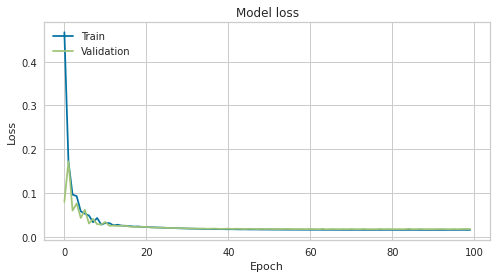

In [ ]:
model, history = RNN_MLP_Model(features, X_train_concatenated, X_test_concatenated,
                               y_train_concatenated, y_test_concatenated, X_lstm, y_lstm, X_concatenated,
                               scalerY, n_steps, start_training = True, plot_learning_curve = True)

In [ ]:
# #optimizer = ['SGD', 'Adam', 'Adamax', 'Nadam'] #'RMSprop', 'Adagrad', 'Adadelta',
# #loss = ["binary_crossentropy", 'categorical_crossentropy', 'sparse_categorical_crossentropy'] #'poisson', 'kl_divergence',
# #init_mode = ['uniform', 'normal'] #'lecun_uniform', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'
# #activation_hidden = ['softmax', 'sigmoid', 'linear'] #'softplus', 'softsign', 'relu', 'tanh', 'hard_sigmoid'
# #activation_output = ['softmax', 'sigmoid', 'linear'] #'softplus', 'softsign', 'relu', 'tanh', 'hard_sigmoid'
# # #dropout_rate = [x * 0.1 for x in range(0, 4, 1)]
# # layers = [x for x in range(2, 4, 1)]
# # neurons = [x for x in range(20, 65, 20)]

# improved_param_grid = dict(
#     batch_size = [x for x in range(64, 65, 64)],
#     # epochs = [x for x in range(200, 300, 25)],
#     validation_split = [x * 0.1 for x in range(2, 3, 1)] # Cannot be 0 or < 0
# )
# param_grid = dict(
#     # init = init_mode, 
#     # activation_hidden = activation_hidden, 
#     # activation_output = activation_output, 
#     GRU_dropout_rate = [x * 0.1 for x in range(0, 1, 1)], 
#     MLP_dropout_rate = [x * 0.1 for x in range(0, 1, 1)],
#     # loss = loss, 
#     # optimizer = optimizer,
#     GRU_neurons = [x for x in range(64, 65, 32)],
#     MLP_neurons = [x for x in range(50, 51, 50)],
#     layers = [x for x in range(1, 2, 1)]
# )

# maxlog, scalerY, features, X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated, X_lstm, y_lstm, X_concatenated = process_data(
#     dataset_with_clustering_profiles_and_metadata)

# # For the grid search only:
# create_model, dataset_list = RNN_MLP_Model(
#     features, X_train_concatenated, X_test_concatenated,
#     y_train_concatenated, y_test_concatenated, X_lstm, y_lstm, X_concatenated,
#     scalerY, n_steps, model_grid_search = True, shuffle = False, param_grid = param_grid)

In [ ]:
def Grid_Search(create_model, dataset_list, epochs = 300, batch_size = 512, validation_split=0.1, shuffle = False, last = False, **param_grid):
    """
    It takes a function that creates a model, a list of datasets, and a dictionary of parameters and
    values, and returns a dictionary of the history and model for each combination of parameters
    
    :param create_model: the function that creates the model
    :param dataset_list: a list of the datasets that are used in the model
    :param epochs: number of epochs to train the model, defaults to 300 (optional)
    :param batch_size: Number of samples per gradient update, defaults to 512 (optional)
    :param validation_split: the percentage of the training data to be used as validation data
    :param last: if True, the model will be trained on the last dataset only. If False, the model will
    be trained on all datasets, defaults to False (optional)
    :return: A dictionary with the following structure:
    """
    X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated, X_lstm, y_lstm, X_concatenated, scalerY = dataset_list
    storage = {}

    keys, values = zip(*param_grid.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    print("Number of total combinations : ", str(len(permutations_dicts)))
    for i, permutations in enumerate(permutations_dicts):
        print("Running through combination    ", str(i+1)+"/"+str(len(permutations_dicts)))
        argument = ""
        for i, (param, value) in enumerate(permutations.items()):
            if i < len(permutations.keys())-1:
                line = str(param)+"="+str(value)+","
                argument += line
            elif i == len(permutations.keys())-1 :
                line = str(param)+"="+str(value)
                argument += line

        model_ready = eval("create_model("+argument+")") 
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35, min_delta=0.0001, restore_best_weights=True)
        model_ready.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=['mae', 'acc'])
        history = model_ready.fit(X_train_concatenated, y_train_concatenated, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=validation_split, shuffle = shuffle, callbacks=[es])
        storage[str(permutations)]=[history, model_ready]

    return storage
# result = Grid_Search(create_model, dataset_list, **param_grid)

# summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
def Improved_Grid_Search(create_model, dataset_list, param_grid, show_learning_curves = False, **improved_param_grid):
    """
    It takes a function that creates a model, a list of datasets, a dictionary of parameters for the
    model, and a dictionary of parameters for the grid search, and returns a dictionary of the best
    models for each combination of parameters
    
    :param create_model: the function that creates the model
    :param dataset_list: a list of tuples of the form (X_train, y_train, X_test, y_test)
    :param param_grid: This is the dictionary of parameters that you want to test
    :param show_learning_curves: If True, it will show the learning curves of the models, defaults to
    False (optional)
    :return: A dictionary with the following structure:
    """
    storage = {}
    keys, values = zip(*improved_param_grid.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    print("Number of total combinations : ", str(len(permutations_dicts)))
    for i, permutations in enumerate(permutations_dicts):
        print("Running through combination    ", str(i+1)+"/"+str(len(permutations_dicts)))
        argument = ""
        for i, (param, value) in enumerate(permutations.items()):
            if i < len(permutations.keys())-1:
                line = str(param)+"="+str(value)+","
                argument += line
            elif i == len(permutations.keys())-1 :
                line = str(param)+"="+str(value)
                argument += line

        history = eval("Grid_Search(create_model, dataset_list, "+argument+",**param_grid)") 
        for key, val in history.items():
            storage[key[:-1]+","+str(permutations)[1:-1]+"}"] = val

    if show_learning_curves:
        for params, history_model_list in storage.items():
            history = history_model_list[0]
            plt.rcParams["figure.figsize"] = [8,4]
            plt.plot(history.history['loss'], label='Train')
            plt.plot(history.history['val_loss'], label='Validation')
            plt.title('Learning Curve of model: '+ params)
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')
            plt.show()
    return storage

In [ ]:
# storage = Improved_Grid_Search(create_model, dataset_list, param_grid, show_learning_curves = True, **improved_param_grid)

In [ ]:
def plot_curves_forecast(real, prediction, title="", y_title=""):
    real = real.reshape(-1, 1)
    assert real.shape == prediction.shape, "Incompatible data shapes: %s vs %s" % (real.shape, prediction.shape)
    %matplotlib inline
    plt.rcParams["figure.figsize"] = [8,4]
    plt.suptitle(title, fontsize=23)
    plt.plot(prediction, label="Predictions")
    plt.plot(real, label="Real values")
    plt.legend(loc="upper left")
    plt.xlabel("1-Hour slot data points", fontsize=18)
    plt.ylabel(y_title, fontsize=18)
    plt.rcParams["legend.title_fontsize"] = "x-large"
    plt.show()

In [ ]:
def denormalize_data(scalerY, maxlog, y_data):
    y_data = y_data.reshape(-1, 1)
    y_data = inv_boxcox(scalerY.inverse_transform(y_data), maxlog)
    return np.where(y_data < 0, 0, y_data) # to be sure only non-negative values are returned.

#### Evaluation after inverse tranformations

In [ ]:
# N.B: doing tests like len(y_data) > 0 instead of y_data != [], to avoid issues with numpy.
def model_prediction(model,
                     X_data,
                     y_data=[],
                     scalerY=None,
                     maxlog=None,
                     rescale=False,
                     for_grid=False,
                     verbose=False,
                     plotting=False):

    y_pred = model.predict(X_data)
    print ('y_pred',type(y_pred))
    evaluation = [] if len(y_data) < 2 else full_model_evaluation(y_data, y_pred, verbose=verbose)

    if rescale and not for_grid: # rescaling disabled for the grid search.
        assert scalerY != None and maxlog != None, "Missing scalerY or maxlog"
        y_pred = denormalize_data(scalerY, maxlog, y_pred)
        if len(y_data) > 0:
            y_data = denormalize_data(scalerY, maxlog, y_data)

    if plotting and not for_grid: # plotting disabled for the grid search.
        assert len(y_data) > 0, "Missing y_data"
        y_title = ("normalized " if rescale else "") + "energy consumption"
        plot_curves_forecast(y_data, y_pred, title="RNN encoder & MLP", y_title=y_title)
        return None # to not print everything.

    return y_pred, evaluation

In [ ]:
def grid_search_to_pandas_evaluation(storage, rescale = False):
    result_list = []
    for params, history_model_list in storage.items():
        history = history_model_list[0]
        model = history_model_list[1]

        y_pred, evaluation = model_prediction(model, X_concatenated, y_data=y_lstm,
            rescale=rescale, scalerY=scalerY, maxlog=maxlog, for_grid=True)

        assert evaluation != [], "Empty evaluation"
        mape, r2, mse, rmse, mae, nrmse, nd, rss, abs_diff_sum, diff_from_mean_sum = evaluation

        # Mean Absolute Percentage Error (MAPE) = 66.61088943758779 %
        # R-squared = 0.648534711459316
        # Mean Squared Error (MSE) = 74716.60607619357
        # Root Mean Squared Error (RMSE) = 273.3433849139093
        # Mean Absolute Error (MAE) = 148.33895479930825
        # Normalized Root Mean Squared Error (NRMSE) = 0.6900984432974919
        # Normalized deviation (ND) = 0.3745050637300809
        # Residual Sum of the Squares (RSS) = 28392310.308953553
        # Sum of absolute differences = 56368.80282373713

        # R2 (high is best) > MAPE (small is best) > RMSE
        params_dict = eval(params)
        params_dict['MSE'] = mse
        params_dict['RMSE'] = rmse
        params_dict['NRMSE'] = nrmse
        params_dict['MAE'] = mae
        params_dict['R^2'] = r2
        params_dict['MAPE'] = mape
        params_dict['ND'] = nd
        params_dict['RSS'] = abs_diff_sum
        params_dict['Dif_From_Mean_Sum'] = diff_from_mean_sum
        params_dict['model'] = model
        result_list.append(params_dict)

    df = pd.DataFrame.from_dict(result_list)
    return df

In [ ]:
X_test_concatenated.shape

Out[49]: (380, 68)

2/2 [==============================] - 0s 7ms/step
y_pred <class 'numpy.ndarray'>


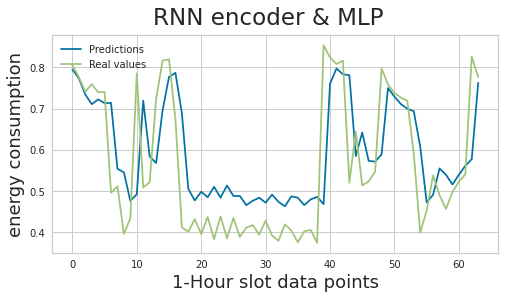

In [ ]:
start, end = 359, 423
model_prediction(model,
                 X_concatenated[start:end],
                 y_data=y_lstm[start:end],
                 scalerY=scalerY,
                 maxlog=maxlog,
                 rescale=False,
                 plotting=True)

2/2 [==============================] - 0s 6ms/step
y_pred <class 'numpy.ndarray'>


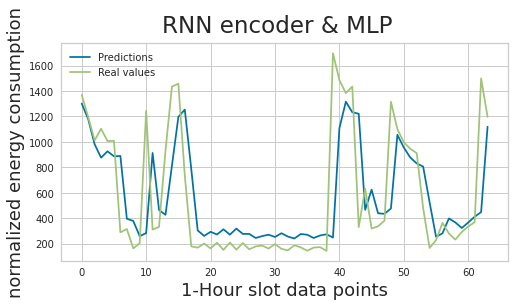

In [ ]:
start, end = 359, 423
model_prediction(model,
                 X_concatenated[start:end],
                 y_data=y_lstm[start:end],
                 scalerY=scalerY,
                 maxlog=maxlog,
                 rescale=True,
                 plotting=True)

1/1 [==============================] - 0s 438ms/step


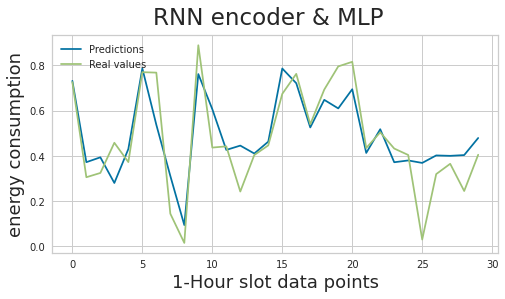

In [ ]:
start, end = 50, 80
model_prediction(model,
                 X_test_concatenated[start:end],
                 y_data=y_test_concatenated[start:end],
                 scalerY=scalerY,
                 maxlog=maxlog,
                 rescale=False,
                 plotting=True)

1/1 [==============================] - 0s 30ms/step
Mean Absolute Percentage Error (MAPE) = 73.82085114717484 %
R-squared = 0.7138428518402319
Mean Squared Error (MSE) = 0.014750469509432504
Root Mean Squared Error (RMSE) = 0.12145151093927363
Mean Absolute Error (MAE) = 0.09126732697789831
Normalized Root Mean Squared Error (NRMSE) = 0.25701969151610454
Normalized deviation (ND) = 14.131600365717638
Residual Sum of the Squares (RSS) = 70.83712559514932
Sum of absolute differences = 200.33144615678495
Difference from mean sum = 1.5464023461539018


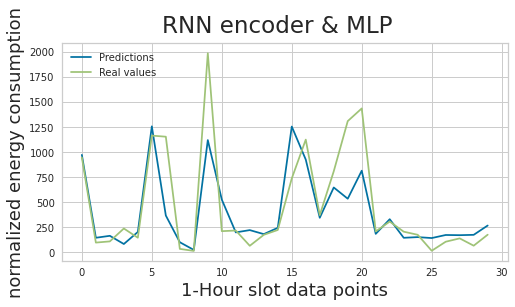

In [ ]:
start, end = 50, 80
model_prediction(model,
                 X_test_concatenated[start:end],
                 y_data=y_test_concatenated[start:end],
                 scalerY=scalerY,
                 maxlog=maxlog,
                 rescale=True,
                 verbose=True,
                 plotting=True)

In [ ]:
# df = grid_search_to_pandas_evaluation(storage, rescale = True)
# df

In [ ]:
# y_pred, evaluation = model_prediction_inv_boxcox(df.iloc[6]["model"], scalerY, X_concatenated, X_test_concatenated, y_test_concatenated, maxlog, plot_prediction_vs_reality = True)

# **INFERENCE**

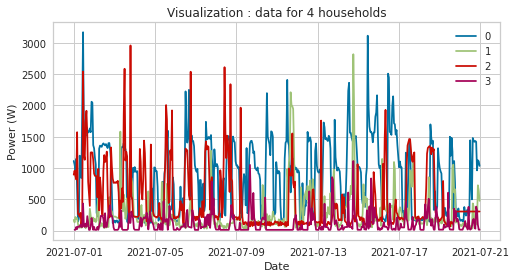

In [ ]:
# Load file and start preprocessing
dataset_with_metadata, df_unique_houses = data_loading_preprocessing(
    "bigg_data.csv", plot_consumption_per_house = False, to_csv_name = dataDir+"dataset_with_metadata.csv")

In [ ]:
clustering_profiles_metadata, load_profiles, clustering_profiles_weekend_weekday_difference_score = consumer_profile_features(
    dataset_with_metadata, to_csv_name = dataDir+"IC_clustering_profiles_metadata.csv")

In [ ]:
clustering_profiles_weekend_weekday_difference_score

,Weekend vs weekday difference score,mean_over_max,min_over_mean,var,mean,max,min,Relative average consumption 1,Relative average consumption 2,Relative average consumption 3,Relative average consumption 4,Mean relative standard deviation
dataid,,,,,,,,,,,,
0,1.410687,0.276307,0.130970,342526.157037,875.714187,3169.347975,114.692350,0.801539,0.561861,1.263641,1.188609,0.659908
1,1.699126,0.097967,0.097482,106694.887040,276.029719,2817.589925,26.908044,0.629146,0.920021,0.889368,1.552937,0.999076
2,1.133667,0.161710,0.134131,253148.650400,478.357386,2958.112197,64.162786,0.695088,0.749449,1.345227,1.159942,0.981387
3,1.873913,0.101477,0.093232,23273.980996,112.788661,1111.469983,10.515567,0.390569,0.858298,1.048528,1.711274,1.156729


In [ ]:
clustering_profiles_timeseries = time_series_clustering(
    load_profiles, path_pickle_load= dataDir+"IC_timeseries_kmeans.pkl", visualise_KMeans_clustering = False,
    to_csv_name = dataDir+"IC_clustering_profiles_timeseries.csv")

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
clustering_profiles_non_timeseries = non_time_series_clustering(
    clustering_profiles_weekend_weekday_difference_score,
    path_pickle_load= dataDir+"IC_non_timeseries_kmeans.pkl", visualise_KMeans_clustering = False,
    to_csv_name = dataDir+"IC_clustering_profiles_non-timeseries.csv")

[[1.41068702e+00 2.76307365e-01 1.30970072e-01 3.42526157e+05
  8.75714187e+02 3.16934798e+03 1.14692350e+02 8.01538813e-01
  5.61860701e-01 1.26364084e+00 1.18860891e+00 6.59908484e-01]
 [1.69912599e+00 9.79666049e-02 9.74824180e-02 1.06694887e+05
  2.76029719e+02 2.81758993e+03 2.69080444e+01 6.29146116e-01
  9.20020598e-01 8.89367977e-01 1.55293734e+00 9.99075883e-01]
 [1.13366659e+00 1.61710359e-01 1.34131484e-01 2.53148650e+05
  4.78357386e+02 2.95811220e+03 6.41627861e+01 6.95087625e-01
  7.49449396e-01 1.34522664e+00 1.15994156e+00 9.81387198e-01]
 [1.87391316e+00 1.01477019e-01 9.32324808e-02 2.32739810e+04
  1.12788661e+02 1.11146998e+03 1.05155667e+01 3.90568584e-01
  8.58298038e-01 1.04852763e+00 1.71127426e+00 1.15672865e+00]]
(4, 12)
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
dataset_with_clustering_profiles_and_metadata = clustering_profiles_and_metadata(
    dataset_with_metadata, 
    clustering_profiles_metadata,
    clustering_profiles_timeseries, 
    clustering_profiles_non_timeseries,
    calculate_centroids = True,
    to_csv_name = dataDir+'IC_dataset_with_clustering_profiles_and_metadata.csv')

In [ ]:
scalerY, X_concatenated_INF, y_lstm_INF = process_data(dataset_with_clustering_profiles_and_metadata, inference=True)

maxlog: 0.1222951965895911
Loaded file: /dbfs/mnt/proactive-dr/ScalerX.pkl
Loaded file: /dbfs/mnt/proactive-dr/ScalerY.pkl
{'feature_range': (0, 1), 'copy': True, 'clip': False, 'n_features_in_': 1, 'n_samples_seen_': 1919, 'scale_': array([0.09081167]), 'min_': array([-0.2475808]), 'data_min_': array([2.72631042]), 'data_max_': array([13.73811093]), 'data_range_': array([11.0118005])}


In [ ]:
print(X_concatenated_INF.shape)
print(y_lstm_INF.shape)

(1896, 68)
(1896,)


2/2 [==============================] - 0s 5ms/step


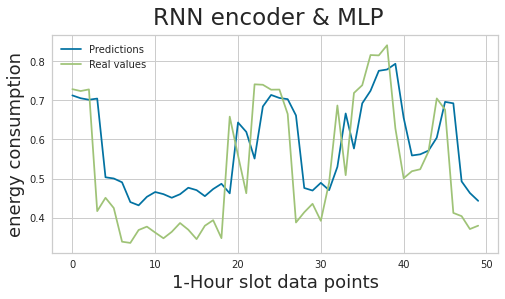

In [ ]:
start, end = 50, 100
model_prediction(model,
                 X_concatenated_INF[start:end],
                 y_data=y_lstm_INF[start:end],
                 scalerY=scalerY,
                 maxlog=maxlog,
                 rescale=False,
                 plotting=True)

2/2 [==============================] - 0s 6ms/step


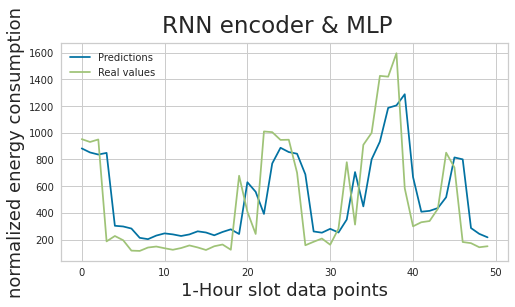

In [ ]:
start, end = 50, 100
model_prediction(model,
                 X_concatenated_INF[start:end],
                 y_data=y_lstm_INF[start:end],
                 scalerY=scalerY,
                 maxlog=maxlog,
                 rescale=True,
                 plotting=True)